# BOCD with SMC2

Extend BOCD with SMC2 for parameter estimation. We will save particles for each time and propagate them if the corresponding element of the vector R containing the growth probability is sufficiently high. We need to define the class for the data

In [1]:
from __future__ import division
from functools import partial
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import stats, poisson
import matplotlib.cm as cm 
import pandas as pd

## Single Region constant rate in time
Assume the following:
- $y_t \sim \text{Poisson}(x^{(t)^2})$ 
- $x_j^{(r_t)} |x_{j-1}^{(r_t)} \sim N(\theta_1^{(r_t)}*x_{j-1}^{(r_t)},\theta_2^{(r_t)})$

we need to estimate the process $x^{(r_t)}$ along with $\theta_1$ and $\theta_2$ 
The prior on the states particles has to be big enough to capture all the possible rates

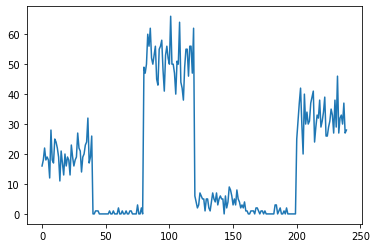

In [2]:
##Generate data

np.random.seed(1234)
#number of changepoints
ncp = 6 
#length of sequences
l = 40
#generate fake rates
rate = np.random.normal(3,3,ncp)**2
D = []
for cp in range(ncp):
    D.append(poisson(rate[cp]).rvs(l))
D = np.array(D).flatten()
plt.plot(D) 

In [3]:
def online_changepoint_detection(data,hazard_func,observation_likelihood):
    #code initially found on
    #https://github.com/hildensia/bayesian_changepoint_detection
    maxes = np.zeros(len(data) + 1)
    params = np.zeros(shape = (2,len(data)+1))
    states =  np.zeros(shape = (2, len(data)))
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    for t, x in enumerate(data):
        #step 3-4
        #print('t =', t)
        # Evaluate the predictive distribution for the new datum for all runlength
        predprobs, expected_params, expected_state = observation_likelihood.pdf(x,R[0:t+1, t])
        
        # Evaluate the hazard function
        H = hazard_func(np.array(range(t+1)))
       
        # Evaluate the growth probabilities 
        #step 5
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        #step 6
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities 
        #step 7
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        #step 8
        observation_likelihood.update_run(x)
        #save parameters for runlength with highest probability
        #step 9
        maxes[t] = R[:, t].argmax()
        params[:,t] = expected_params[:, int(maxes[t])]
        states[:,t] = expected_state[:,int(maxes[t])]
    #return estimated parameters and prediction (only for time dependency case)
        #print('state = ', states[:,t])
        #print(R[0:t+2, t+1])
    return R, params, states

def constant_hazard(lam, r):
    return 1/lam * (np.ones(r.shape))

In [4]:
class Single_Region_SMC(): 
    #the function _init_ is the builder
    def __init__(self,mean_x, sigma_x, mean_theta,sigma_theta, N_x, N_theta, N_params, link_func): 
        self.r = []
        self.mean_x = mean_x
        self.sigma_x = sigma_x
        self.mean_theta =mean_theta
        self.sigma_theta = sigma_theta
        self.link_func = link_func
        self.N_x = N_x
        self.N_theta = N_theta
        self.N_params = N_params
        self.particles_states =[]
        self.particles_params = []
        self.weights_states= []
        self.w = []

    def next_step(self,states, a,b):
        a = np.tile((a),(self.N_x,1)).T
        b = np.tile((b),(self.N_x,1)).T
        #b was set to .05 in other experiments
        newX = a*states + b*np.random.rand(self.N_theta,self.N_x)
        return(newX)   

    def update_run(self, x):
        #save the data collected up to this point
        #you save the most recent element in position 0
        self.r.insert(0,x)

    #evaluate likelihood using SMC2 with simple reshuffling as rejuvenation step
    def pdf(self, data, R):
        lik = []
        t = len(self.r)+1
        expected_param = np.zeros(shape=(2,t))
        expected_state = np.zeros(shape=(2,t))

        #initialise the particles for the new point only 
        curr_particles_states = np.random.normal(self.mean_x, self.sigma_x, (self.N_theta, self.N_x))
        #generate prior parameters for both a and b
        #(here we simply use same prior but this is easily extended)
        
        curr_param_states = np.random.multivariate_normal(self.mean_theta, self.sigma_theta*np.eye(self.N_params), (self.N_theta))
        #evaluate weights
        curr_weights_states = (poisson.pmf(data, self.link_func(curr_particles_states)))
        curr_w = np.mean(curr_weights_states, axis = 1)
        
        lik.append(np.mean(curr_w))
         
        self.particles_states.insert(0, curr_particles_states)
        self.particles_params.insert(0, curr_param_states)
        self.weights_states.insert(0, curr_weights_states)
        self.w.insert(0, curr_w)  
        
        plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[0]/np.sum(self.w[0])).astype(int)
        expected_param[:,0] = [np.average(self.particles_params[0][:,0], weights = self.w[0], axis = 0), np.std(self.particles_params[0][:,0][plot_index])]
        expected_state[:,0] = [np.average(np.average(self.link_func(self.particles_states[0]),weights = self.weights_states[0],axis = 1), weights = self.w[0], axis = 0), np.std(np.average(self.link_func(self.particles_states[0]),weights = self.weights_states[0],axis = 1)[plot_index])]

        if(t>1):
            for i in range(1,t):
                if(R[i] < 10**(-3)*5):
                    lik.append(0)
                    #delete particles
                    self.particles_states[i] = [0]
                    self.particles_params[i] = [0]
                    self.weights_states[i] = [0]
                    self.w[i] = [0]
                    continue
                X_curr =  np.zeros((self.N_theta, self.N_x))# self.particles_states[i]
                norm_weights = self.weights_states[i]/(np.tile(np.sum(self.weights_states[i], axis =1),(self.N_x,1)).T)
                A_index = np.zeros((self.N_theta,self.N_x))            # tensor containing the indexes
                for k in range(self.N_theta):
                    #update indexes
                    A_index[k,:] = np.random.choice(list(range(self.N_x)), size = (self.N_x),replace = True, p = norm_weights[k,:])
                    #sample the particles 
                    X_curr[k,:] = self.particles_states[i][k, A_index[k,:].astype(int)]
                
                curr_particles_states = self.next_step(np.array(X_curr), *(self.particles_params[i].T))
                #print(curr_particles_states.shape)
                curr_weights_states = (poisson.pmf(data, self.link_func(curr_particles_states)))
                curr_w = np.mean(curr_weights_states, axis = 1)
        
                lik.append(np.mean(curr_w))
                
                self.particles_states[i] = curr_particles_states 
                self.weights_states[i] = curr_weights_states
                self.w[i] = curr_w*self.w[i]
                n_eff = np.sum(self.w[i])**2/(np.sum(self.w[i]**2))
                
                #discard useless paths before it degenerates
                if(n_eff < .6*self.N_theta):
                    index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                    self.w[i] = np.ones_like(self.w[i])
                    self.particles_states[i] = self.particles_states[i][index]
                    self.weights_states[i] = self.weights_states[i][index]
                    self.particles_params[i] = self.particles_params[i][index]
                
                plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                #print(plot_index)
                expected_param[:,i] = [np.average(self.particles_params[i][:,0], weights = self.w[i], axis = 0), np.std(self.particles_params[i][:,0][plot_index])]
                expected_state[:,i] = [np.average(np.average(self.link_func(self.particles_states[i]),weights = self.weights_states[i],axis = 1), weights = self.w[i], axis = 0), np.std(np.average(self.link_func(self.particles_states[i]),weights = self.weights_states[i],axis = 1)[plot_index])]
        return lik, expected_param, expected_state

In [5]:
R, expected_params, states = online_changepoint_detection(D, partial(constant_hazard, 250), Single_Region_SMC(mean_x = 3, sigma_x = 2 , mean_theta = .5*np.ones(2), sigma_theta = .25*np.ones(2), N_x =2500, N_theta=3000, N_params =2, link_func = np.square))

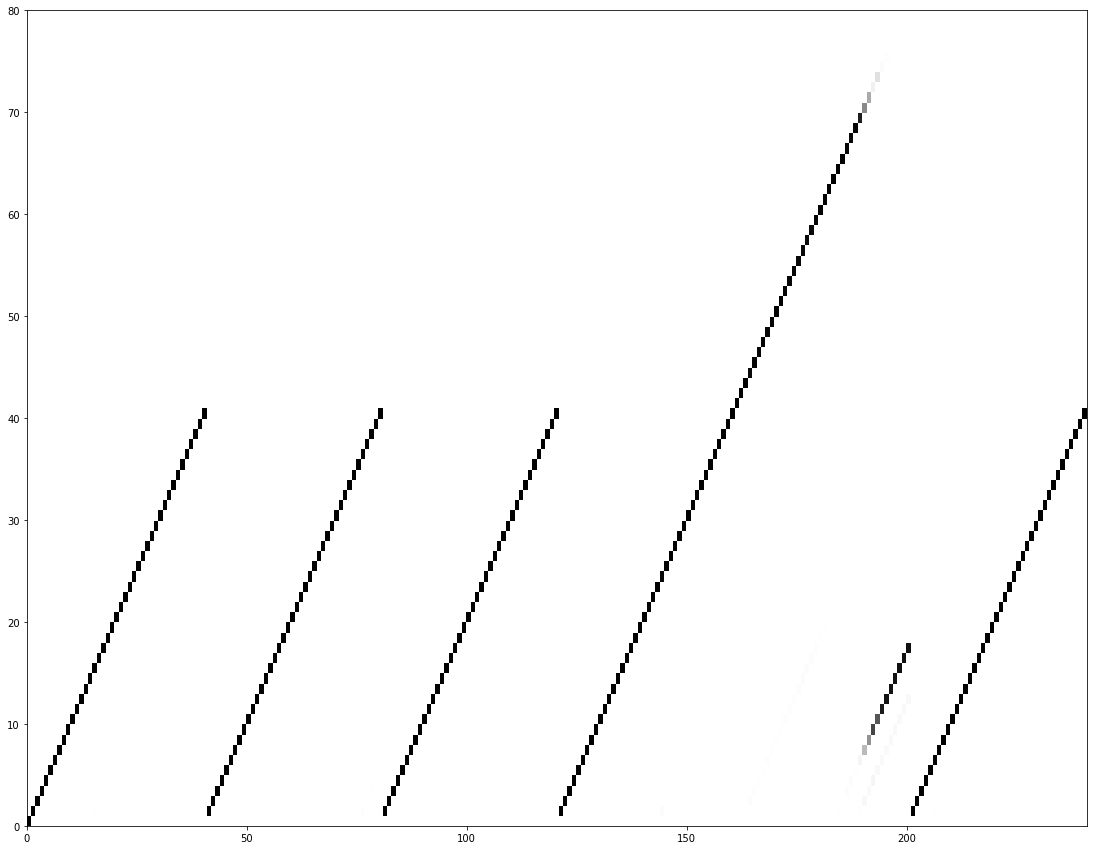

In [6]:
plt.figure(figsize = (19,15))
plt.pcolor(np.array(range(0,len(R[:,0])+1)),
          np.array(range(0,len(R[0:80,0])+1)),
          (R[0:80,:]),
           cmap = cm.Greys,vmin = 0 ,vmax = 1
          )

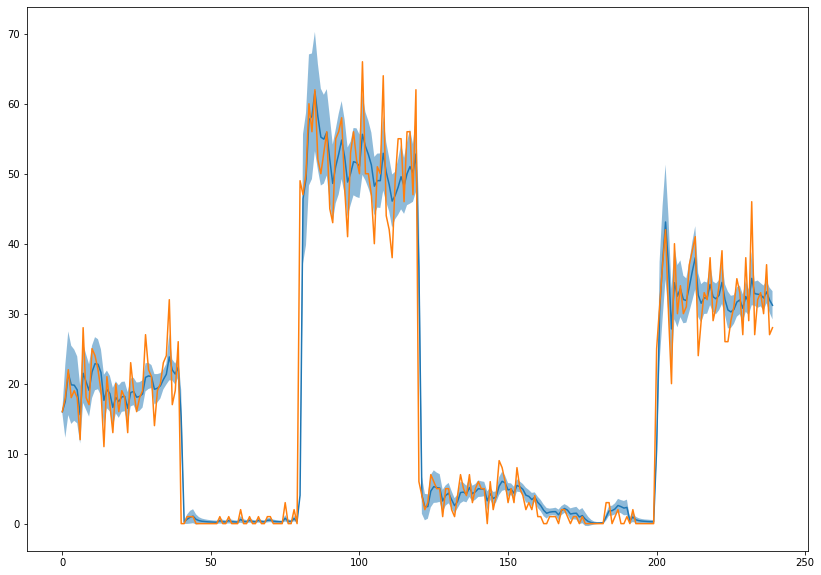

In [7]:
plt.figure(figsize = (14,10))
plt.plot(states[0,:])
plt.fill_between(np.arange(len(states[0,:])), states[0,:] - 2* states[1,:], states[0,:] + 2* states[1,:], alpha = .5)
plt.plot(D)

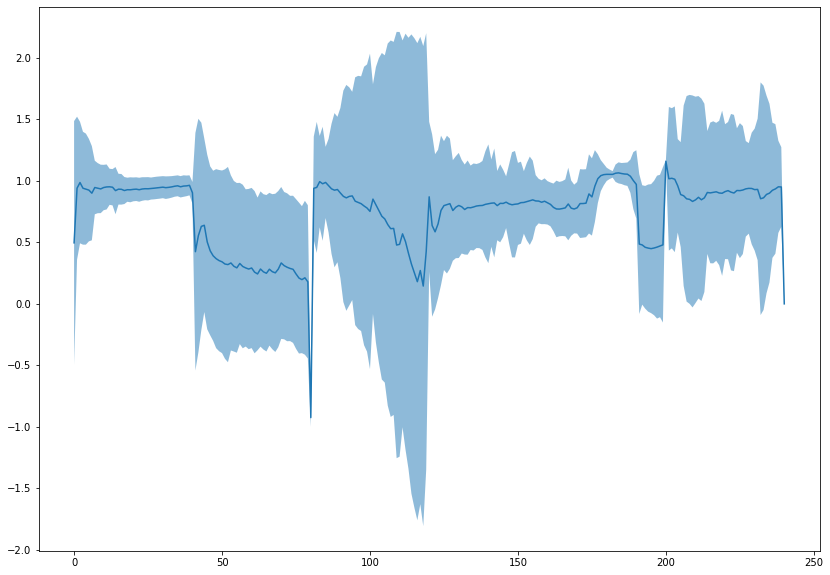

In [8]:
plt.figure(figsize = (14,10))
plt.plot(expected_params[0,0:300])
plt.fill_between(np.arange(len(expected_params[0,0:300])), expected_params[0,0:300] - 2* expected_params[1,0:300], expected_params[0,0:300] + 2* expected_params[1,0:300], alpha = .5)

# Time varying

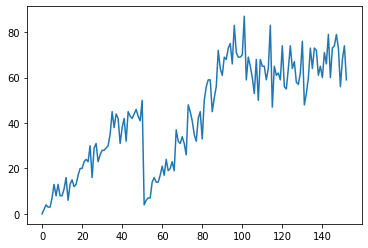

In [9]:
np.random.seed(224)
#gamma = np.array([1,5,4])
gamma = np.array([1,5,60])
a = [1, 1.5, .2]
b = [.2,.2, .2]

process_gamma = []
for i in range(0,3):
    process_gamma.append(gamma[i])
    for t  in range(50):
        err = np.random.randn(1)
        process_gamma.append(a[i]+process_gamma[-1] + b[i]*err)
Rates = np.abs(np.array(process_gamma))

D = [poisson(Rates[i]).rvs(1) for i in range(len(Rates))]
plt.plot(D)

In [10]:
class Single_Region_SMC_half(): 
    #the function _init_ is the builder
    def __init__(self,mean_x, sigma_x, mean_theta,sigma_theta, N_x, N_theta, N_params, link_func): 
        self.r = []
        self.mean_x = mean_x
        self.sigma_x = sigma_x
        self.mean_theta =mean_theta
        self.sigma_theta = sigma_theta
        self.N_x = N_x
        self.N_theta = N_theta
        self.N_params = N_params
        self.particles_states =[]
        self.particles_params = []
        self.weights_states= []
        self.w = []
        self.link_func = link_func

    def next_step(self,states, a, b):
        a = np.tile((a),(self.N_x,1)).T
        b = np.tile((b),(self.N_x,1)).T
        #different model
        newX = a + states + b*np.random.rand(self.N_theta,self.N_x)
        return(newX)   

    def update_run(self, x):
        #save the data collected up to this point
        #you save the most recent element in position 0
        self.r.insert(0,x)

    def pdf(self, data, R):
        lik = []
        t = len(self.r)+1
        expected_param = np.zeros(shape=(2,t))
        expected_state = np.zeros(shape=(2,t))

        #initialise the particles for the new point only 
        curr_particles_states = np.random.normal(self.mean_x, self.sigma_x, (self.N_theta, self.N_x))**2
        if(self.N_params == 1):
            curr_param_states = np.random.normal(self.mean_theta, self.sigma_theta, (self.N_theta, self.N_params))
        else:
            curr_param_states = np.random.multivariate_normal(self.mean_theta, self.sigma_theta*np.eye(self.N_params), (self.N_theta))
        #evaluate weights
        curr_weights_states = (poisson.pmf(data, self.link_func(curr_particles_states)))
        curr_w = np.mean(curr_weights_states, axis = 1)
        
        lik.append(np.mean(curr_w))
         
        self.particles_states.insert(0, curr_particles_states)
        self.particles_params.insert(0, curr_param_states)
        self.weights_states.insert(0, curr_weights_states)
        self.w.insert(0, curr_w)
        plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[0]/np.sum(self.w[0])).astype(int)
        expected_param[:,0] = [np.average(self.particles_params[0][:,0], weights = self.w[0], axis = 0), np.std(self.particles_params[0][:,0][plot_index])]
        expected_state[:,0] = [np.average(np.average((self.particles_states[0])**2,weights = self.weights_states[0],axis = 1), weights = self.w[0], axis = 0), np.std(np.average((self.particles_states[0]**2),weights = self.weights_states[0],axis = 1)[plot_index])]

        if(t>1):
            for i in range(1,t):
                if(R[i] < 10**(-3)*5):
                    lik.append(0)
                    #delete particles
                    self.particles_states[i] = [0]
                    self.particles_params[i] = [0]
                    self.weights_states[i] = [0]
                    self.w[i] = [0]
                    continue
                X_curr = np.zeros((self.N_theta, self.N_x))
                norm_weights = self.weights_states[i]/(np.tile(np.sum(self.weights_states[i], axis =1),(self.N_x,1)).T)
                A_index = np.zeros((self.N_theta,self.N_x))            # tensor containing the indexes
                for k in range(self.N_theta):
                    #update indexes
                    A_index[k,:] = np.random.choice(list(range(self.N_x)), size = (self.N_x),replace = True, p = norm_weights[k,:])
                    #sample the particles 
                    X_curr[k,:] = self.particles_states[i][k, A_index[k,:].astype(int)]
                
                curr_particles_states = self.next_step(np.array(X_curr), *(self.particles_params[i].T))
                curr_weights_states = (poisson.pmf(data, self.link_func(curr_particles_states)))
                curr_w = np.mean(curr_weights_states, axis = 1)
        
                lik.append(np.mean(curr_w))
                
                self.particles_states[i] = curr_particles_states
                self.weights_states[i] = curr_weights_states
                self.w[i] = curr_w*self.w[i]
               # print(self.particles_params[i][(np.isnan(self.w[i]))])
                n_eff = np.sum(self.w[i])**2/(np.sum(self.w[i]**2))
                
                #discard useless paths before it degenerates
                if(n_eff < .6*self.N_theta):
                    index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                    self.w[i] = np.ones_like(self.w[i])
                    self.particles_states[i] = self.particles_states[i][index]
                    self.weights_states[i] = self.weights_states[i][index]
                    self.particles_params[i] = self.particles_params[i][index]
                
                plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                expected_param[:,i] = [np.average(self.particles_params[i][:,0], weights = self.w[i], axis = 0), np.std(self.particles_params[i][:,0][plot_index])]
                expected_state[:,i] = [np.average(np.average(self.link_func(self.particles_states[i]),weights = self.weights_states[i],axis = 1), weights = self.w[i], axis = 0), np.std(np.average(self.link_func(self.particles_states[i]),weights = self.weights_states[i],axis = 1)[plot_index])]

        return lik, expected_param, expected_state

In [11]:
R, expected_params, states = online_changepoint_detection(D, partial(constant_hazard, 250), Single_Region_SMC_half(mean_x = 4, sigma_x = 3 , mean_theta = .7*np.ones(2), sigma_theta = 1*np.ones(2), N_x =2500, N_theta=3000, N_params =2, link_func = np.abs) )

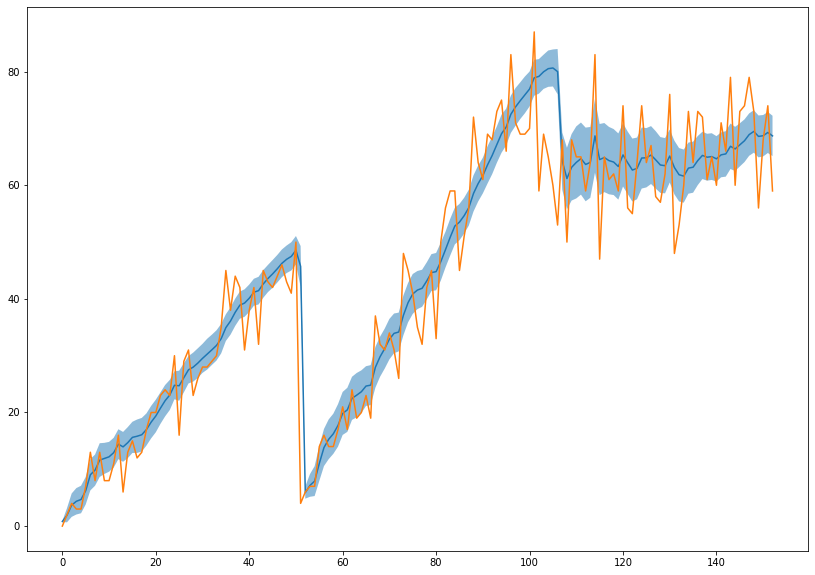

In [12]:
plt.figure(figsize = (14,10))
plt.plot(states[0,:])
plt.fill_between(np.arange(len(states[0,:])), states[0,:] - 2* states[1,:], states[0,:] + 2* states[1,:], alpha = .5)
plt.plot(D)

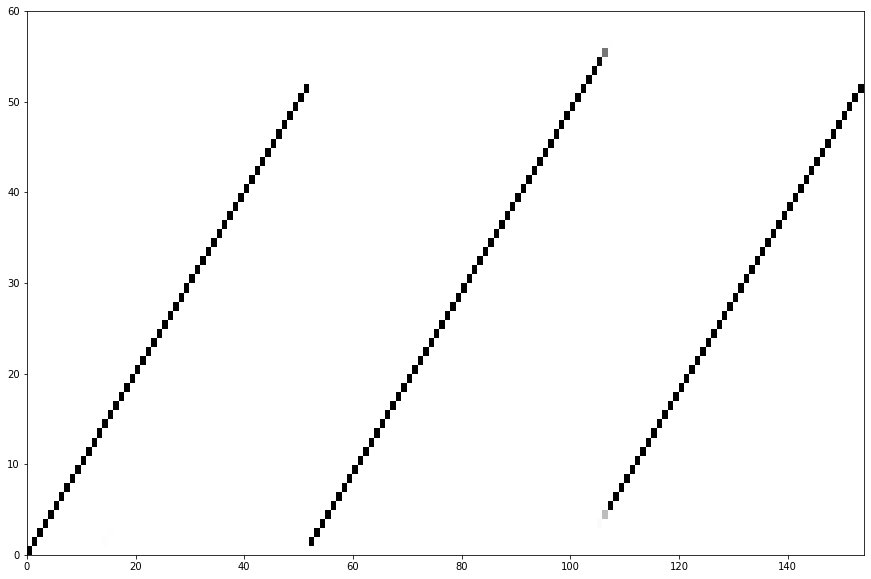

In [13]:
plt.figure(figsize = (15,10))
plt.pcolor(np.array(range(0,len(R[:,0])+1)),
          np.array(range(0,len(R[0:60,0])+1)),
          (R[0:61,:]),
           cmap = cm.Greys,vmin = 0 ,vmax = 1
          )

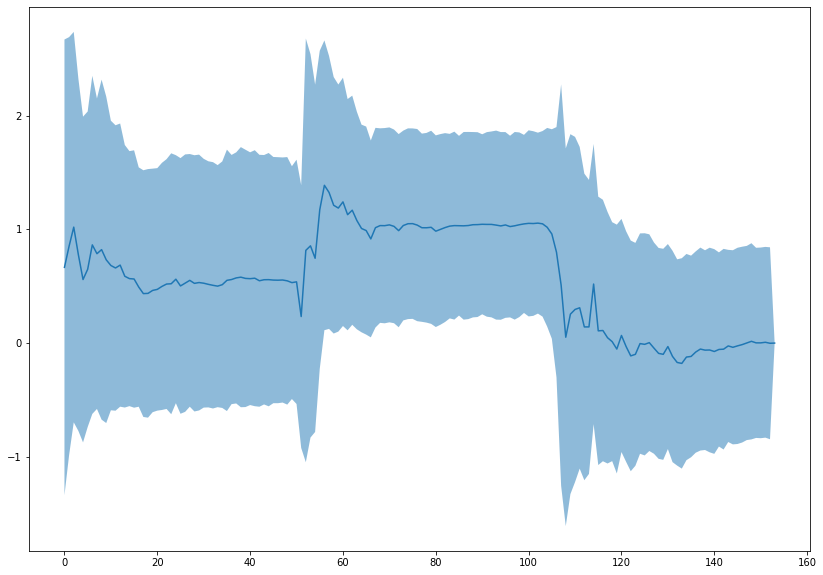

In [14]:
plt.figure(figsize = (14,10))
plt.plot(expected_params[0,:])
plt.fill_between(np.arange(len(expected_params[0,:])), expected_params[0,:] - 2* expected_params[1,:], expected_params[0,:] + 2* expected_params[1,:], alpha = .5)


# ACLED data

/home/crovinie96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/crovinie96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 175 entries, (2005, 1) to (2019, 7)
Data columns (total 1 columns):
count    175 non-null int64
dtypes: int64(1)
memory usage: 2.1 KB


/home/crovinie96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/crovinie96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


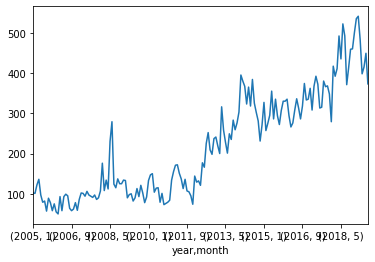

In [15]:
data_africa = pd.read_csv("1900-01-01-2019-08-07-Eastern_Africa-Middle_Africa-Northern_Africa-Southern_Africa-Western_Africa.csv")
data_VAC = data_africa[data_africa['event_type'] == 'Violence against civilians']
#data_VAC = data_VAC[data_africa['region'] == 'Northern Africa']
VAC = data_VAC[['event_date','fatalities']]
VAC['timestamp'] =pd.to_datetime(data_VAC.event_date, infer_datetime_format= True)
VAC['month'] = pd.DatetimeIndex(VAC['event_date']).month
VAC['year'] = pd.DatetimeIndex(VAC['event_date']).year

VAC_togroup = VAC[['year', 'month']]
VAC_togroup['count'] = 1

filtered = VAC_togroup[(VAC_togroup['year']>=2005)]
filtered = filtered[filtered['year']<=2019]

filtered = filtered.groupby(['year','month']).sum()

D = filtered['count']

np.savetxt('VAC_Data.txt', D, delimiter = ',')
D.plot()
filtered.info()
D = D.values

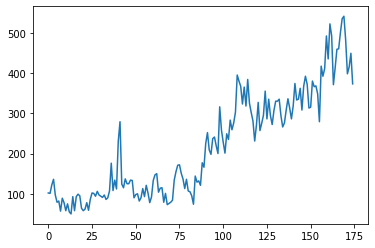

In [16]:
plt.plot(D)

In [78]:
class Single_Region_SMC(): 
    #the function _init_ is the builder
    def __init__(self,mean_x, sigma_x, mean_theta,sigma_theta, N_x, N_theta, N_params, link_func): 
        self.r = []
        self.mean_x = mean_x
        self.sigma_x = sigma_x
        self.mean_theta =mean_theta
        self.sigma_theta = sigma_theta
        self.link_func = link_func
        self.N_x = N_x
        self.N_theta = N_theta
        self.N_params = N_params
        self.particles_states =[]
        self.particles_params = []
        self.weights_states= []
        self.w = []

    def next_step(self,states, a, b):
        a = np.tile((a),(self.N_x,1)).T
        b = np.tile((b),(self.N_x,1)).T
        newX = a + b*states + .1*np.random.rand(self.N_theta,self.N_x)
        
        return(newX)   

    def update_run(self, x):
        #save the data collected up to this point
        #you save the most recent element in position 0
        self.r.insert(0,x)

    def pdf(self, data, R):
        lik = []
        t = len(self.r)+1
        expected_param = np.zeros(shape=(2,t))
        expected_state = np.zeros(shape=(2,t))

        #initialise the particles for the new point only 
        curr_particles_states = np.random.normal(self.mean_x, self.sigma_x, (self.N_theta, self.N_x))
  
        curr_param_states = np.random.multivariate_normal(self.mean_theta, self.sigma_theta*np.eye(self.N_params), (self.N_theta))

        #evaluate weights
        curr_weights_states = (poisson.pmf(data, self.link_func(curr_particles_states)))
        curr_w = np.mean(curr_weights_states, axis = 1)
        
        lik.append(np.mean(curr_w))
         
        self.particles_states.insert(0, curr_particles_states)
        self.particles_params.insert(0, curr_param_states)
        self.weights_states.insert(0, curr_weights_states)
        self.w.insert(0, curr_w)
        plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[0]/np.sum(self.w[0])).astype(int)
        expected_param[:,0] = [np.average(self.particles_params[0][:,0], weights = self.w[0], axis = 0), np.std(self.particles_params[0][:,0][plot_index])]
        expected_state[:,0] = [np.average(np.average(np.exp(self.particles_states[0]),weights = self.weights_states[0],axis = 1), weights = self.w[0], axis = 0), np.std(np.average(np.exp(self.particles_states[0]),weights = self.weights_states[0],axis = 1)[plot_index])]

        if(t>1):
            for i in range(1,t):
                if(R[i] < 10**(-3)*5):
                    lik.append(0)
                    #delete particles
                    self.particles_states[i] = [0]
                    self.particles_params[i] = [0]
                    self.weights_states[i] = [0]
                    self.w[i] = [0]
                    continue
                X_curr = np.zeros((self.N_theta, self.N_x))
                norm_weights = self.weights_states[i]/(np.tile(np.sum(self.weights_states[i], axis =1),(self.N_x,1)).T)
                A_index = np.zeros((self.N_theta,self.N_x))            # tensor containing the indexes
                for k in range(self.N_theta):
                    #update indexes
                    A_index[k,:] = np.random.choice(list(range(self.N_x)), size = (self.N_x),replace = True, p = norm_weights[k,:])
                    #sample the particles 
                    X_curr[k,:] = self.particles_states[i][k, A_index[k,:].astype(int)]
                
                curr_particles_states = self.next_step(np.array(X_curr), *(self.particles_params[i].T))
                curr_weights_states = (poisson.pmf(data, np.exp(curr_particles_states)))
                curr_w = np.mean(curr_weights_states, axis = 1)
        
                lik.append(np.mean(curr_w))
                
                self.particles_states[i] = curr_particles_states
                self.weights_states[i] = curr_weights_states
                self.w[i] = curr_w*self.w[i]
               # print(self.particles_params[i][(np.isnan(self.w[i]))])
                n_eff = np.sum(self.w[i])**2/(np.sum(self.w[i]**2))
                #discard useless paths before it degenerates
                if(n_eff < .6*self.N_theta):
                    index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                    self.w[i] = np.ones_like(self.w[i])
                    self.particles_states[i] = self.particles_states[i][index]
                    self.weights_states[i] = self.weights_states[i][index]
                    self.particles_params[i] = self.particles_params[i][index]
                
                plot_index = np.random.choice(list(range(self.N_theta)), size = (self.N_theta),replace = True, p = self.w[i]/np.sum(self.w[i])).astype(int)
                #print(plot_index)
                expected_param[:,i] = [np.average(self.particles_params[i][:,0], weights = self.w[i], axis = 0), np.std(self.particles_params[i][:,0][plot_index])]
                expected_state[:,i] = [np.average(np.average(np.exp(self.particles_states[i]),weights = self.weights_states[i],axis = 1), weights = self.w[i], axis = 0), np.std(np.average(np.exp(self.particles_states[i]),weights = self.weights_states[i],axis = 1)[plot_index])]

        return lik, expected_param, expected_state

In [87]:
R, expected_params, states = online_changepoint_detection(D, partial(constant_hazard, 250), Single_Region_SMC(mean_x = 5, sigma_x = 2 , mean_theta = np.array([2.5,0]), sigma_theta = np.array([2.5,1]), N_x =1300, N_theta=1300, N_params =2, link_func = np.exp)) #.5 gives the results as in the MSc thesis

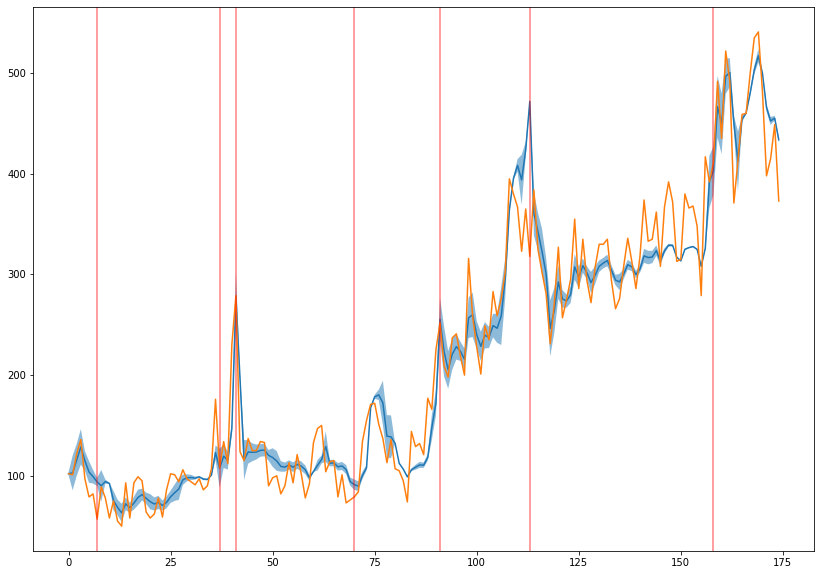

In [102]:
plt.figure(figsize = (14,10))
plt.plot(states[0,:])
plt.fill_between(np.arange(len(states[0,:])), states[0,:] - 2* states[1,:], states[0,:] + 2* states[1,:], alpha = .5)
plt.plot(D)

plt.axvline(7, color = 'red', alpha = .5)
plt.axvline(37, color = 'red', alpha = .5)
plt.axvline(41, color = 'red', alpha = .5)
plt.axvline(70, color = 'red', alpha = .5)
plt.axvline(91, color = 'red', alpha = .5)
plt.axvline(113, color = 'red', alpha = .5)
plt.axvline(158, color = 'red', alpha = .5)

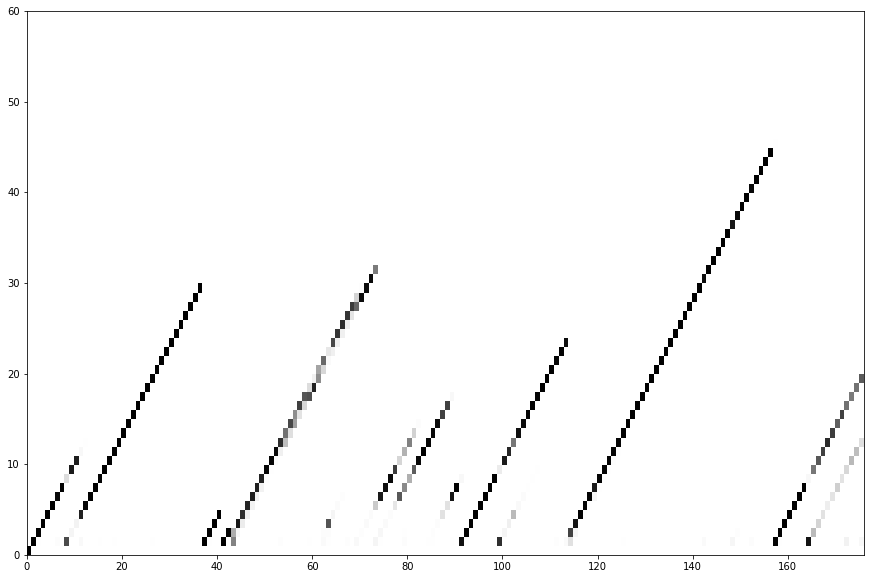

In [89]:
plt.figure(figsize = (15,10))
plt.pcolor(np.array(range(0,len(R[:,0])+1)),
          np.array(range(0,len(R[0:60,0])+1)),
          (R[0:61,:]),
           cmap = cm.Greys,vmin = 0 ,vmax = 1
          )

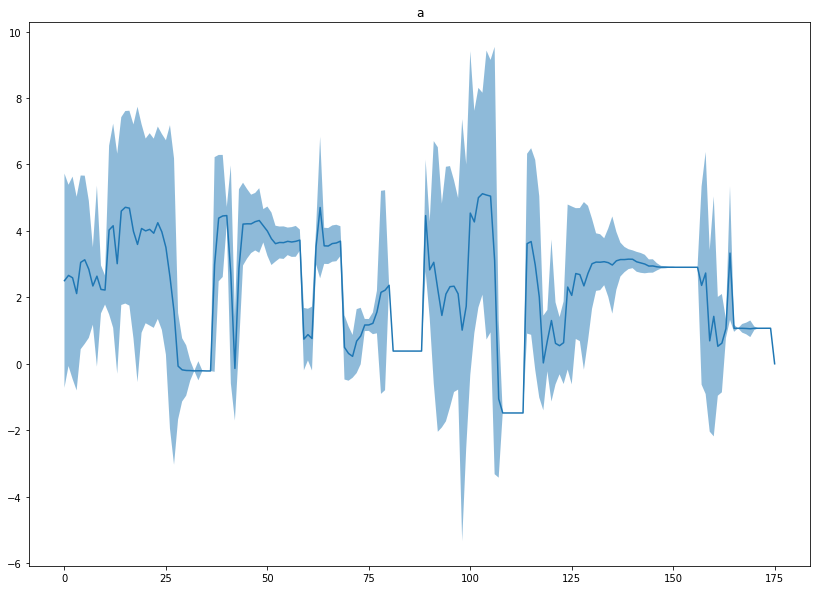

In [104]:
plt.figure(figsize = (14,10))
plt.plot(expected_params[0,:])
plt.title('a')
plt.fill_between(np.arange(len(expected_params[0,:])), expected_params[0,:] - 2* expected_params[1,:], expected_params[0,:] + 2* expected_params[1,:], alpha = .5)